# Fastag Fraud Detection

This project focuses on leveraging machine learning classification techniques to develop an
effective fraud detection system for Fastag transactions. The dataset comprises key features such as
transaction details, vehicle information, geographical location, and transaction amounts. The goal is to
create a robust model that can accurately identify instances of fraudulent activity, ensuring the integrity
and security of Fastag transactions.

In [102]:
pip install -U imbalanced-learn



[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip



     ---------------------------------------- 0.0/258.3 kB ? eta -:--:--
     -------------------------------------  256.0/258.3 kB 5.2 MB/s eta 0:00:01
     -------------------------------------  256.0/258.3 kB 5.2 MB/s eta 0:00:01
     -------------------------------------  256.0/258.3 kB 5.2 MB/s eta 0:00:01
     -------------------------------------  256.0/258.3 kB 5.2 MB/s eta 0:00:01
     -------------------------------------- 258.3/258.3 kB 1.1 MB/s eta 0:00:00


In [254]:
#importing required libraries
import pandas as pd
import numpy as np
import seaborn as sns
from collections import Counter
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score,classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import warnings

warnings.filterwarnings('ignore')

In [172]:
#Reading the data file
dataset=pd.read_csv("FastagFraudDetection.csv")

#head() function is used to retrive the first n rows. Default n=5. 
dataset.head(5)

,Transaction_ID,Timestamp,Vehicle_Type,FastagID,TollBoothID,Lane_Type,Vehicle_Dimensions,Transaction_Amount,Amount_paid,Geographical_Location,Vehicle_Speed,Vehicle_Plate_Number,Fraud_indicator
0,1,1/6/2023 11:20,Bus,FTG-001-ABC-121,A-101,Express,Large,350,120,"13.059816123454882, 77.77068662374292",65,KA11AB1234,Fraud
1,2,1/7/2023 14:55,Car,FTG-002-XYZ-451,B-102,Regular,Small,120,100,"13.059816123454882, 77.77068662374292",78,KA66CD5678,Fraud
2,3,1/8/2023 18:25,Motorcycle,NaN,D-104,Regular,Small,0,0,"13.059816123454882, 77.77068662374292",53,KA88EF9012,Not Fraud
3,4,1/9/2023 2:05,Truck,FTG-044-LMN-322,C-103,Regular,Large,350,120,"13.059816123454882, 77.77068662374292",92,KA11GH3456,Fraud
4,5,1/10/2023 6:35,Van,FTG-505-DEF-652,B-102,Express,Medium,140,100,"13.059816123454882, 77.77068662374292",60,KA44IJ6789,Fraud


In [173]:
#information about the columns of the dataset
print(dataset.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Transaction_ID         5000 non-null   int64 
 1   Timestamp              5000 non-null   object
 2   Vehicle_Type           5000 non-null   object
 3   FastagID               4451 non-null   object
 4   TollBoothID            5000 non-null   object
 5   Lane_Type              5000 non-null   object
 6   Vehicle_Dimensions     5000 non-null   object
 7   Transaction_Amount     5000 non-null   int64 
 8   Amount_paid            5000 non-null   int64 
 9   Geographical_Location  5000 non-null   object
 10  Vehicle_Speed          5000 non-null   int64 
 11  Vehicle_Plate_Number   5000 non-null   object
 12  Fraud_indicator        5000 non-null   object
dtypes: int64(4), object(9)
memory usage: 507.9+ KB
None


### Data Cleaning

Every dataset can contain dirty,null,unnecessary,corrupt values. Therefore, before proceeding with the computation,
cleaning or cleansing of the data is essential. Data Cleaning or Data Cleansing is the process of removing corrupt or 
inaccurate entries from the dataset. 

In [174]:
#Remove duplicate values if any
dataset.drop_duplicates(inplace=True)

#checking for null values in the dataset
dataset.isnull().sum()

Transaction_ID             0
Timestamp                  0
Vehicle_Type               0
FastagID                 549
TollBoothID                0
Lane_Type                  0
Vehicle_Dimensions         0
Transaction_Amount         0
Amount_paid                0
Geographical_Location      0
Vehicle_Speed              0
Vehicle_Plate_Number       0
Fraud_indicator            0
dtype: int64

There are 549 null FastagID values which is a string value. Deleting the entire column for further analysis.

In [175]:
#Deleting the entire FastagID column
dataset=dataset.drop(['FastagID'],axis=1)

#checking for null values in the dataset
dataset.isnull().sum()

Transaction_ID           0
Timestamp                0
Vehicle_Type             0
TollBoothID              0
Lane_Type                0
Vehicle_Dimensions       0
Transaction_Amount       0
Amount_paid              0
Geographical_Location    0
Vehicle_Speed            0
Vehicle_Plate_Number     0
Fraud_indicator          0
dtype: int64

In [176]:
#Printing Unique values of every column
for i in dataset:
    print(i,": ",dataset[i].unique())

Transaction_ID :  [   1    2    3 ... 4998 4999 5000]
Timestamp :  ['1/6/2023 11:20' '1/7/2023 14:55' '1/8/2023 18:25' ... '2/5/2023 5:08'
 '2/20/2023 20:34' '3/10/2023 0:59']
Vehicle_Type :  ['Bus ' 'Car' 'Motorcycle' 'Truck' 'Van' 'Sedan' 'SUV']
TollBoothID :  ['A-101' 'B-102' 'D-104' 'C-103' 'D-105' 'D-106']
Lane_Type :  ['Express' 'Regular']
Vehicle_Dimensions :  ['Large' 'Small' 'Medium']
Transaction_Amount :  [350 120   0 140 160 180 290 110 100 130  60 150 340 300  70 115 145 330
  90 125]
Amount_paid :  [120 100   0 160  90 180 350 140 110  60 290 130  70 190 150 340  80 300
  50 115 145 330 125]
Geographical_Location :  ['13.059816123454882, 77.77068662374292'
 '13.042660878688794, 77.47580097259879'
 '12.84197701525119, 77.67547528176169'
 '12.936687032945434, 77.53113977439017'
 '13.21331620748757, 77.55413526894684']
Vehicle_Speed :  [ 65  78  53  92  60 105  70  88  45  72  58  81  67  98  50  75  62  84
  55  80  68  90  48  77  63  87  52  95  73  82  57  96  66  89  51 

In [177]:
#Splitting the data into feature and target variable x = feature columns and y=target variable
x=dataset.iloc[:,:-1]
y=dataset.iloc[:,-1]

In [178]:
#Removing unnecessary columns
x=x.drop(['Transaction_ID','TollBoothID','Vehicle_Plate_Number','Timestamp'],axis=1)

### Exploratory Data Analysis (EDA)

Exploratory Data Analysis is a method of systematically going through the data, computing summary statistics and finding the relationships between all the variables. 

<b> Summary Statistics</b>

Once the data is cleaned, we need to understand the statistics of the data. Statistical Analysis tells us about the data. 
Statistical knowledge helps you to employ the correct analyses and effectively present the results.

In [126]:
#Descriptive Statistics of the dataset
x.describe()

,Transaction_Amount,Amount_paid,Vehicle_Speed
count,5000.00000,5000.000000,5000.000000
mean,161.06200,141.261000,67.851200
std,112.44995,106.480996,16.597547
min,0.00000,0.000000,10.000000
25%,100.00000,90.000000,54.000000
50%,130.00000,120.000000,67.000000
75%,290.00000,160.000000,82.000000
max,350.00000,350.000000,118.000000


KDE Plot for Transaction_Amount and Amount_paid

<AxesSubplot: xlabel='Transaction_Amount', ylabel='Density'>

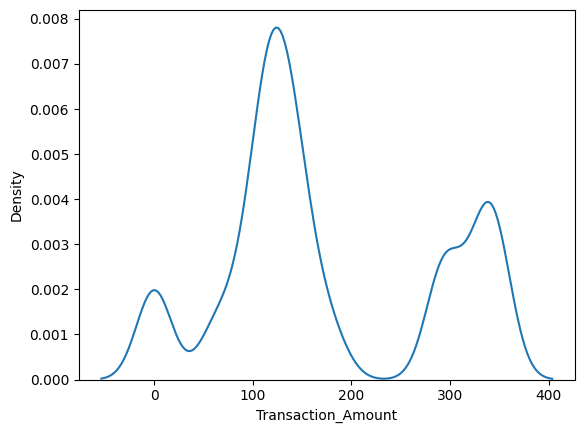

In [249]:
ax = sns.kdeplot(x['Transaction_Amount'])
#sns.kdeplot(x['Amount_paid'], ax=ax)
ax

Number of Fraud Cases

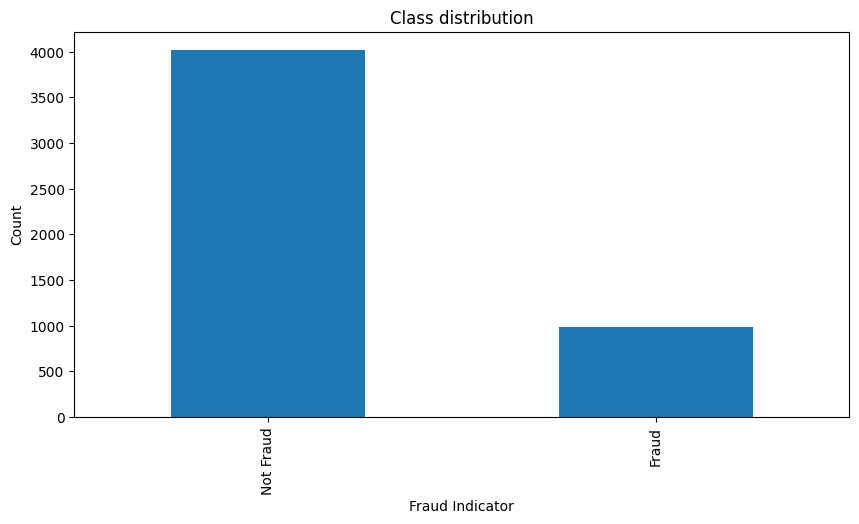

In [247]:
a=dataset['Fraud_indicator'].value_counts()
plt.figure(figsize=(10,5))
a.plot(kind='bar')
plt.title("Class distribution")
plt.ylabel("Count")
plt.xlabel("Fraud Indicator")
plt.show()

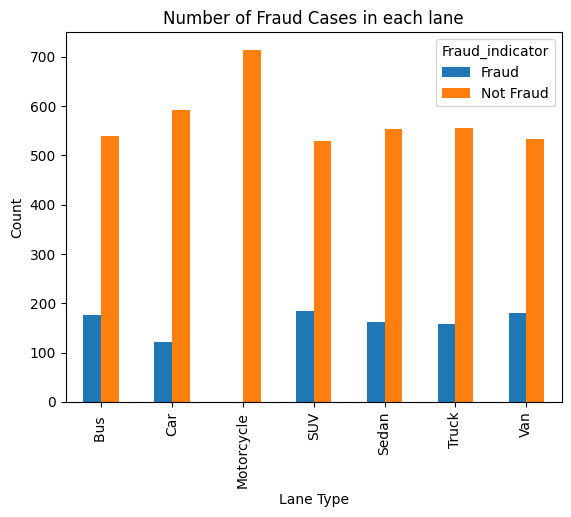

In [129]:
vehicleFraud=dataset.groupby(['Vehicle_Type','Fraud_indicator']).size().reset_index(name='Count').fillna(0)
vehicleFraud = vehicleFraud.pivot(index='Vehicle_Type', columns='Fraud_indicator', values='Count')

vehicleFraud.plot(kind='bar')
plt.xlabel("Lane Type")
plt.ylabel("Count")
plt.title("Number of Fraud Cases in each lane")
plt.show()

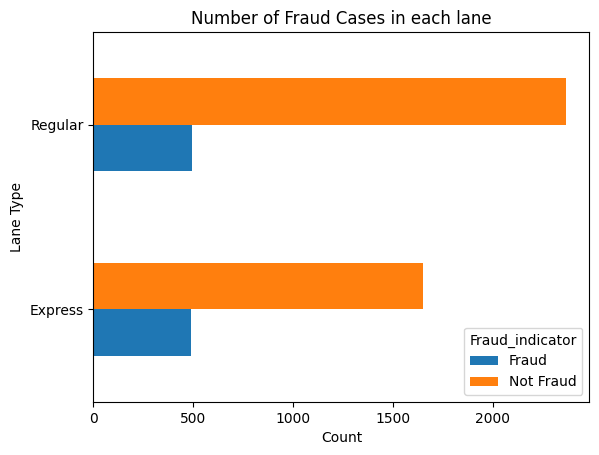

In [130]:
laneType=dataset.groupby(['Lane_Type','Fraud_indicator']).size().reset_index(name='Count').fillna(0)
laneType = laneType.pivot(index='Lane_Type', columns='Fraud_indicator', values='Count')

laneType.plot(kind='barh')
plt.ylabel("Lane Type")
plt.xlabel("Count")
plt.title("Number of Fraud Cases in each lane")
plt.show()

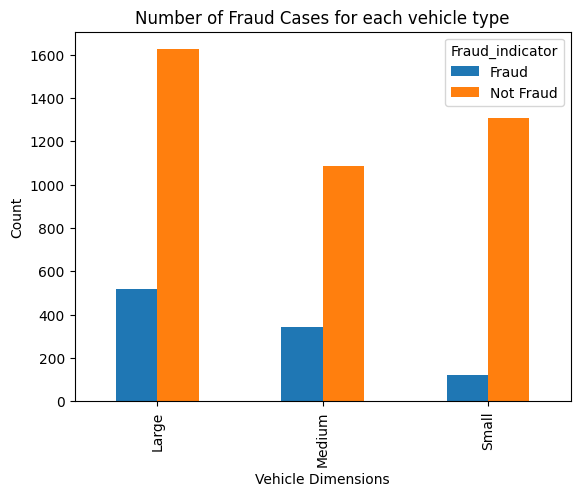

In [131]:
vehicleDimensions=dataset.groupby(['Vehicle_Dimensions','Fraud_indicator']).size().reset_index(name='Count').fillna(0)
vehicleDimensions = vehicleDimensions.pivot(index='Vehicle_Dimensions', columns='Fraud_indicator', values='Count')

vehicleDimensions.plot(kind='bar')
plt.xlabel("Vehicle Dimensions")
plt.ylabel("Count")
plt.title("Number of Fraud Cases for each vehicle type")
plt.show()

The dataset is highly imbalaced. From the above plot, it is clear that the dataset is a bit imbalanced. 'Not Fraud' has more number of samples than 'Fraud'.

In [179]:
#Oversampling
random=RandomOverSampler(sampling_strategy='minority')
x,y=random.fit_resample(x,y)
print(Counter(y))

Counter({'Fraud': 4017, 'Not Fraud': 4017})


Fraud        4017
Not Fraud    4017
Name: Fraud_indicator, dtype: int64


Text(0.5, 1.0, 'Class distribution')

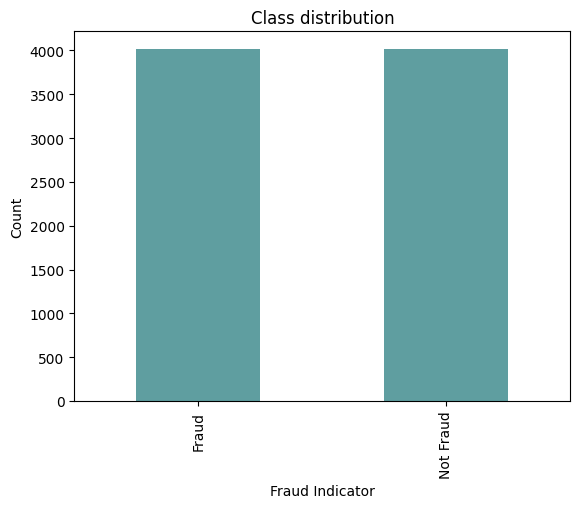

In [180]:
#Class distribution with respect to the number of occurrences in the dataset after oversampling
print(y.value_counts())
y.value_counts().plot(kind="bar",color='cadetblue')
plt.xlabel("Fraud Indicator")
plt.ylabel("Count")
plt.title("Class distribution")

In [181]:
#Converting the Georgraphical Location into Longitude and Latitude in type float
x[['XCord','YCord']]=x['Geographical_Location'].str.split(",",expand=True)
x['XCord']=x['XCord'].astype(float)

x['YCord']=x['YCord'].astype(float)
x=x.drop(['Geographical_Location'],axis=1)
x

,Vehicle_Type,Lane_Type,Vehicle_Dimensions,Transaction_Amount,Amount_paid,Vehicle_Speed,XCord,YCord
0,Bus,Express,Large,350,120,65,13.059816,77.770687
1,Car,Regular,Small,120,100,78,13.059816,77.770687
2,Motorcycle,Regular,Small,0,0,53,13.059816,77.770687
3,Truck,Regular,Large,350,120,92,13.059816,77.770687
4,Van,Express,Medium,140,100,60,13.059816,77.770687
...,...,...,...,...,...,...,...,...
8029,Bus,Express,Large,350,90,59,13.059816,77.770687
8030,Truck,Regular,Large,340,130,93,12.841977,77.675475
8031,Sedan,Regular,Medium,110,100,59,12.936687,77.531140
8032,Sedan,Regular,Medium,100,90,76,13.042661,77.475801


### Encoding

In [182]:
#Converting the categorical columns like Lane_Type, Vehicle_Dimension etc into Numerical format using LabelEncoder
le=LabelEncoder()
x['Lane_Type']=le.fit_transform(x['Lane_Type'])
x['Vehicle_Dimensions']=le.fit_transform(x['Vehicle_Dimensions'])

#Encoding Vehicle_Type using OneHotEncoder
one=OneHotEncoder(sparse_output=False)
vehicleType=x['Vehicle_Type'].values.reshape(-1,1)
vehicleType=one.fit_transform(vehicleType)
encodedDf=pd.DataFrame(vehicleType,columns=one.get_feature_names_out(['Vehicle_Type']))
x=pd.concat([x,encodedDf],axis=1)
x=x.drop(['Vehicle_Type'],axis=1)

x

,Lane_Type,Vehicle_Dimensions,Transaction_Amount,Amount_paid,Vehicle_Speed,XCord,YCord,Vehicle_Type_Bus,Vehicle_Type_Car,Vehicle_Type_Motorcycle,Vehicle_Type_SUV,Vehicle_Type_Sedan,Vehicle_Type_Truck,Vehicle_Type_Van
0,0,0,350,120,65,13.059816,77.770687,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,2,120,100,78,13.059816,77.770687,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,1,2,0,0,53,13.059816,77.770687,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,1,0,350,120,92,13.059816,77.770687,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0,1,140,100,60,13.059816,77.770687,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8029,0,0,350,90,59,13.059816,77.770687,1.0,0.0,0.0,0.0,0.0,0.0,0.0
8030,1,0,340,130,93,12.841977,77.675475,0.0,0.0,0.0,0.0,0.0,1.0,0.0
8031,1,1,110,100,59,12.936687,77.531140,0.0,0.0,0.0,0.0,1.0,0.0,0.0
8032,1,1,100,90,76,13.042661,77.475801,0.0,0.0,0.0,0.0,1.0,0.0,0.0


### Modeling

In [222]:
#Splitting the dataset into training and testing. setting stratify as y ('Class' column) so that there are equal proportions of all the class labels in the training and the testing dataset. 
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42,stratify=y)

#Standardizing the data
scaler=StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

<b>Logistic Regression</b>

Logistic regression is a supervised machine learning algorithm that accomplishes binary classification tasks by predicting the probability of an outcome, event, or observation.

In [243]:
linear=LogisticRegression()

#hyperparameters for Logistic Regression 
linearParams={
    'penalty':['l1', 'l2'],
    'C':[1,2,3]
}

#GridSearchCV is used for looping in all the hyperparameters and then fitting the model based on the hyperparameters. 
#estimator: denotes the model to fit . 
#param_grid: hyperparameters to pass
#cv=cross validation.  
#GridSearchCV considers all the possible combinations of hyperparameters and fits the model
linearGrid=GridSearchCV(linear,param_grid=linearParams,cv=5,scoring='accuracy')

#Fitting the model
linearGrid.fit(X_train,y_train)
linearPred=linearGrid.predict(X_test)
linearAccuracy=accuracy_score(linearPred,y_test)
print("Accuracy is",linearAccuracy)

Accuracy is 0.9664404223227753


In [232]:
#best_params_ denotes the best combination of hyperparameters which can bring in the highest accuracy
print("Best Hyperparameters are",linearGrid.best_params_)

#best_score_ denotes the mean cross validation score
print("Mean Cross Validation score is",linearGrid.best_score_)

Best Hyperparameters are {'C': 3, 'penalty': 'l2'}
Mean Cross Validation score is 0.9678561196770596


              precision    recall  f1-score   support

       Fraud       0.93      1.00      0.97      1241
   Not Fraud       1.00      0.94      0.97      1411

    accuracy                           0.97      2652
   macro avg       0.97      0.97      0.97      2652
weighted avg       0.97      0.97      0.97      2652



Text(0.5, 1.0, 'Classification Report using Logistic Regression')

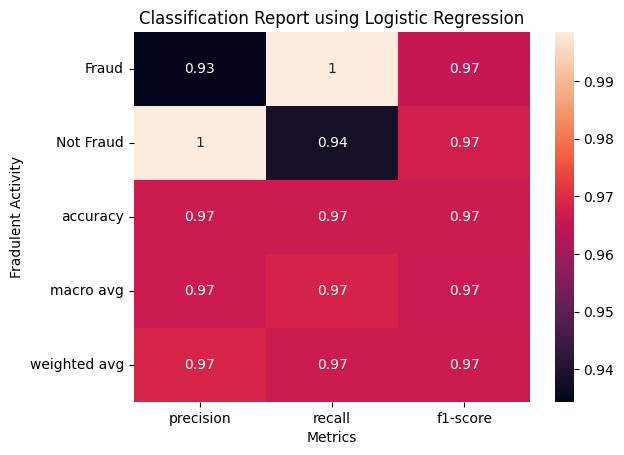

In [233]:
#Classification report denotes the precision, recall and f1 score of the model
matrix=classification_report(linearPred,y_test,output_dict=True)
print(classification_report(linearPred,y_test))
sns.heatmap(pd.DataFrame(matrix).iloc[:-1, :].T,annot=True)
plt.xlabel("Metrics")
plt.ylabel("Fradulent Activity")
plt.title("Classification Report using Logistic Regression")

<b>Decision Tree</b>

The decision tree is a supervised learning algorithm that can be used for both Regression and Classification problems. The decision tree learns simple decision rules from the data and tries to predict the class that belongs to a sample to which it belongs. It decides the label by dividing the sample inputs into smaller decisions. 

In [244]:
dtree=DecisionTreeClassifier()
dtreeParam={
           'criterion':['gini', 'entropy', 'log_loss'],
           'splitter':['best', 'random'],
           'max_depth':[1,2,3,4,5]
}
dtreeGrid=GridSearchCV(dtree,param_grid=dtreeParam,cv=5,scoring='accuracy')
dtreeGrid.fit(X_train,y_train)
dtreePred=dtreeGrid.predict(X_test)

dTreeAccuracy=accuracy_score(dtreePred,y_test)
print("Accuracy is",dTreeAccuracy)

Accuracy is 0.9230769230769231


In [235]:
#best_params_ denotes the best combination of hyperparameters which can bring in the highest accuracy
print("Best Hyperparameters are",dtreeGrid.best_params_)

#best_score_ denotes the mean cross validation score
print("Mean Cross Validation score is",dtreeGrid.best_score_)

Best Hyperparameters are {'criterion': 'gini', 'max_depth': 5, 'splitter': 'best'}
Mean Cross Validation score is 0.9262383807423209


              precision    recall  f1-score   support

       Fraud       0.85      1.00      0.92      1122
   Not Fraud       1.00      0.87      0.93      1530

    accuracy                           0.92      2652
   macro avg       0.92      0.93      0.92      2652
weighted avg       0.93      0.92      0.92      2652



Text(0.5, 1.0, 'Classification Report using Decision Tree')

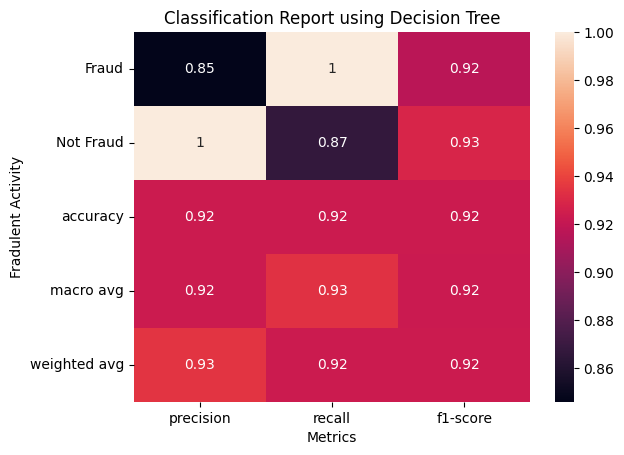

In [265]:
#Classification report denotes the precision, recall and f1 score of the model
matrix=classification_report(dtreePred,y_test,output_dict=True)
print(classification_report(dtreePred,y_test))
sns.heatmap(pd.DataFrame(matrix).iloc[:-1, :].T,annot=True)
plt.xlabel("Metrics")
plt.ylabel("Fradulent Activity")
plt.title("Classification Report using Decision Tree")

<b> Random Forest Classifier</b>

A Random forest is an ensemble learning method combining multiple decision trees, enhancing prediction accuracy, reducing overfitting, and providing insights.

In [245]:
randomF=RandomForestClassifier()
randomFParam={
            'n_estimators':[50,100,150,200,250,300,350,400],
            'max_features':['auto','sqrt'],
            'max_depth':[2,3,4,5]
}
randomGrid=GridSearchCV(randomF,param_grid=randomFParam,scoring='accuracy',cv=5)
randomGrid.fit(X_train,y_train)
randomPred=randomGrid.predict(X_test)

randomForestAccuracy=accuracy_score(y_test,randomPred)
print("Accuracy is",randomForestAccuracy)

Accuracy is 0.952865761689291


In [241]:
#best_params_ denotes the best combination of hyperparameters which can bring in the highest accuracy
print("Best Hyperparameters are",randomGrid.best_params_)

#best_score_ denotes the mean cross validation score
print("Mean Cross Validation score is",randomGrid.best_score_)

Best Hyperparameters are {'max_depth': 5, 'max_features': 'auto', 'n_estimators': 250}
Mean Cross Validation score is 0.949833455868394


              precision    recall  f1-score   support

       Fraud       0.94      0.97      0.95      1288
   Not Fraud       0.97      0.94      0.96      1364

    accuracy                           0.96      2652
   macro avg       0.96      0.96      0.96      2652
weighted avg       0.96      0.96      0.96      2652



Text(0.5, 1.0, 'Classification Report using Random Forest')

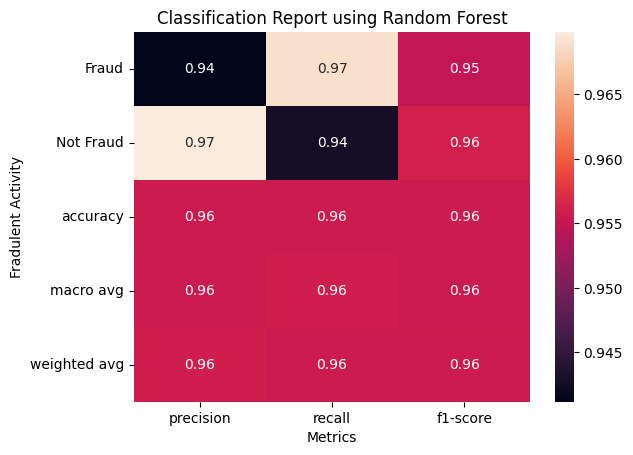

In [242]:
#Classification report denotes the precision, recall and f1 score of the model
matrix=classification_report(randomPred,y_test,output_dict=True)
print(classification_report(randomPred,y_test))
sns.heatmap(pd.DataFrame(matrix).iloc[:-1, :].T,annot=True)
plt.xlabel("Metrics")
plt.ylabel("Fradulent Activity")
plt.title("Classification Report using Random Forest")

                     Accuracy Score
Model                              
Logistic Regression       96.644042
Random Forest             95.286576
Decision Tree             92.307692


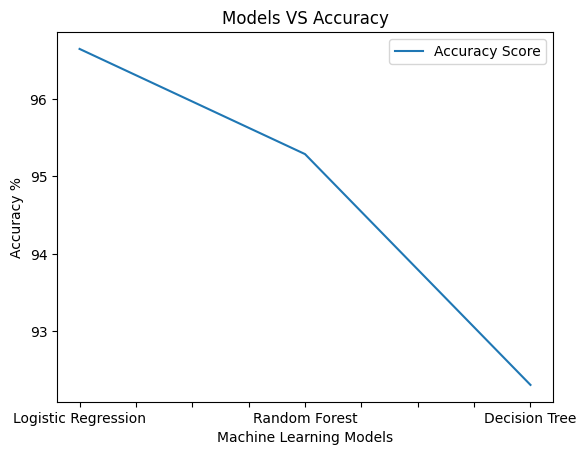

In [246]:
accuracy=pd.DataFrame({'Model':['Logistic Regression','Decision Tree','Random Forest'],
                    'Accuracy Score':[linearAccuracy*100,dTreeAccuracy*100,randomForestAccuracy*100]})
accuracy_df=accuracy.sort_values(by='Accuracy Score', ascending=False)
accuracy_df=accuracy_df.set_index('Model')
print(accuracy_df)


accuracy_df.plot(kind='line')
plt.xlabel("Machine Learning Models")
plt.ylabel("Accuracy %")
plt.title("Models VS Accuracy")
plt.show()

Thus, Logistic Regression can be used as and effective and scalable Fastag fraud detection system capable of minimizing financial losses and ensuring the security of digital toll transactions.